<a href="https://colab.research.google.com/github/Stegi56/Body-Fat-Estimator/blob/main/Face_Covering_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

Set up torch

In [1]:
import torch #ref Lab 9
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Load Google drive and get files

In [2]:
import os
os.environ["OPENCV_ENABLE_NONFREE"] = "1"
from google.colab import drive

drive.mount('/content/drive')

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Face Covering Detection'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)

print(os.listdir(GOOGLE_DRIVE_PATH))

Mounted at /content/drive
['CV2024_CW_Dataset.zip', 'CV2024_CW_Dataset', 'Report template.docx', 'Coursework UG - Sit.pdf', 'Marking scheme.pdf', 'Coursework UG - Sit.gdoc', 'Face Covering Detection.ipynb']


Load Zip File (Ref Lab 9)

In [3]:
# Identify path to zipped dataset
zip_path = os.path.join(GOOGLE_DRIVE_PATH, 'CV2024_CW_Dataset.zip')

# Copy it to Colab
!cp '{zip_path}' .

# Unzip it (removing useless files stored in the zip)
!yes|unzip -q CV2024_CW_Dataset.zip

# Delete zipped version from Colab (not from Drive)
!rm CV2024_CW_Dataset.zip

## Load images and labels

I am using downsampling and upsampling since the majority class is significantly greater and I fear duplication on this scale would risk overfitting.

Ref Lab 6


In [271]:
from skimage import io
from skimage.transform import resize
import numpy as np
import cv2
from collections import Counter
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from PIL import Image

def crop_and_resize(img, target_shape=(128, 128)): #ref https://cloudinary.com/guides/bulk-image-resize/python-image-resize-with-pillow-and-opencv
    im = Image.fromarray(img)
    # Center-crop to square
    min_side = min(im.size)
    left = (im.width - min_side) // 2
    top = (im.height - min_side) // 2
    right = left + min_side
    bottom = top + min_side
    im_cropped = im.crop((left, top, right, bottom))
    # Resize to target shape
    im_resized = im_cropped.resize(target_shape, Image.BILINEAR)
    return np.array(im_resized)

def import_selected_data(type):
  images = []
  labels = []

  for image in os.listdir(os.path.join(type, "images")):
    img = io.imread(os.path.join(type, "images", image))
    img_resized = crop_and_resize(img)

    images.append(img_resized)
    match open(
      os.path.join(type, "labels", image.split(".")[0] + ".txt"),
      "r"
      ).read():
      case "0":
        label = "no mask"
      case "1":
        label = "good mask"
      case "2":
        label = "bad mask"

    labels.append(label)

  return images, labels

X_train, y_train = [], []
X_train_balanced, y_train_balanced = [], []
X_test, y_test = [], []
X_validation, y_validation = [], []

def loadDataImbalanced():
  global X_train, y_train, X_test, y_test

  X, y = import_selected_data("train")

  flipped_images = []
  flipped_labels = []
  for img, label in zip(X, y):
      if label == "bad mask":
          flipped = cv2.flip(img, 1)
          flipped_images.append(flipped)
          flipped_labels.append(label)

  X.extend(flipped_images)
  y.extend(flipped_labels)

  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.2, shuffle=True, stratify=y)


def makeDataBalanced():
  global X_train_balanced, y_train_balanced, X_test, y_test, X_validation, y_validation
  loadDataImbalanced()

  X_train_indexes = np.arange(len(X_train)).reshape(-1, 1) # convert images to indexes for sampling

  undersample_strategy = {"good mask": 500}
  rus = RandomUnderSampler(sampling_strategy=undersample_strategy, random_state=56)


  pipeline = Pipeline([("undersample", rus)]) #combine samplers

  # Resample indices
  X_balanced_indexes, y_train_balanced = pipeline.fit_resample(
      X_train_indexes, y_train
  )

  indices = X_balanced_indexes.ravel()
  X_train_balanced = [X_train[i] for i in indices] #rebuild images using generated indexes

makeDataBalanced()

print("\nUnbalanced training data:")
print(Counter(y_train))

print("\nBalanced training data:")
print(Counter(y_train_balanced))
print(len(X_train_balanced))

print("\nTest data:")
print(Counter(y_test))

X_validation, y_validation = import_selected_data("test")

print("\nValidation data:")
print(Counter(y_validation))


Unbalanced training data:
Counter({'good mask': 1551, 'no mask': 301, 'bad mask': 125})

Balanced training data:
Counter({'no mask': 301, 'good mask': 300, 'bad mask': 125})
726

Test data:
Counter({'good mask': 389, 'no mask': 75, 'bad mask': 31})

Validation data:
Counter({'good mask': 388, 'no mask': 51, 'bad mask': 19})


# SIFT + SVM

## Get points of interest

Ref Lab 6

In [53]:
from skimage import img_as_ubyte, color
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn import svm, metrics
from sklearn.model_selection import GridSearchCV
from joblib import dump

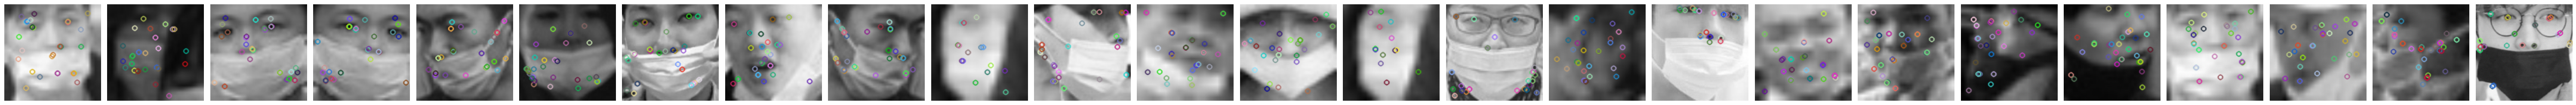

In [54]:
makeDataBalanced()

sift = cv2.SIFT_create(
    nfeatures=30,
    nOctaveLayers=15,
    contrastThreshold=0.01,
    edgeThreshold=10,
    sigma=1.000001
)

des_list = []
y_train_list = []


fig, ax = plt.subplots(1, 25, figsize=(60, 60))

for i in range(len(X_train_balanced)):
    img = img_as_ubyte(color.rgb2gray(X_train_balanced[i]))
    kp, des = sift.detectAndCompute(img, None)

    if i<25:
        img_with_SIFT = cv2.drawKeypoints(img, kp, img)
        ax[i].imshow(img_with_SIFT)
        ax[i].set_axis_off()

    if des is not None:
        des_list.append(des)
        y_train_list.append(y_train_balanced[i])

fig.tight_layout()
plt.show()

# Convert to array for easier handling
des_array = np.vstack(des_list)


Clustering descriptors & Generate histograms of codewords Ref Lab 6



In [55]:
k = len(np.unique(y_train)) * 15

# Use MiniBatchKMeans for faster computation and lower memory usage
batch_size = des_array.shape[0]
kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size, n_init='auto').fit(des_array)

# Convert descriptors into histograms of codewords for each image
hist_list = []
idx_list = []

for des in des_list:
    hist = np.zeros(k)

    idx = kmeans.predict(des)
    idx_list.append(idx)
    for j in idx:
        hist[j] = hist[j] + (1 / len(des))
    hist_list.append(hist)

hist_array = np.vstack(hist_list)

## Train SVM

In [56]:
# Create a classifier: a support vector classifier
classifier = svm.SVC(C=1.0, kernel='rbf', gamma=0.1)
params = {'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]}
classifier = GridSearchCV(classifier, params, cv=5) #ref https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
classifier.fit(hist_array, y_train_list)

print("Best C:", classifier.best_params_['C'])
print("Best score:", classifier.best_score_)

dump(classifier, 'SIFT_SVM.joblib')

Best C: 10
Best score: 0.5633333333333332


['SIFT_SVM.joblib']

In [58]:
from joblib import load
classifier = load('SIFT_SVM.joblib') #ref lab 6

## Analysis SIFT + SVM

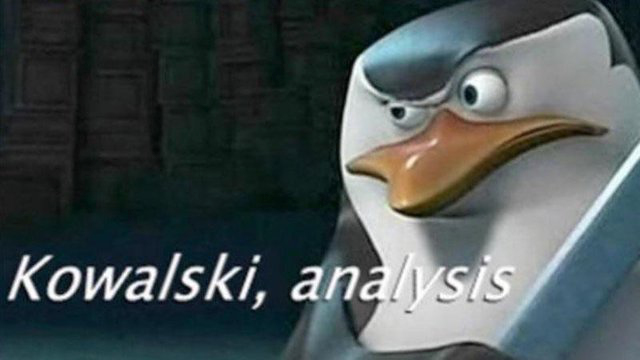

ref penguins of madagascar


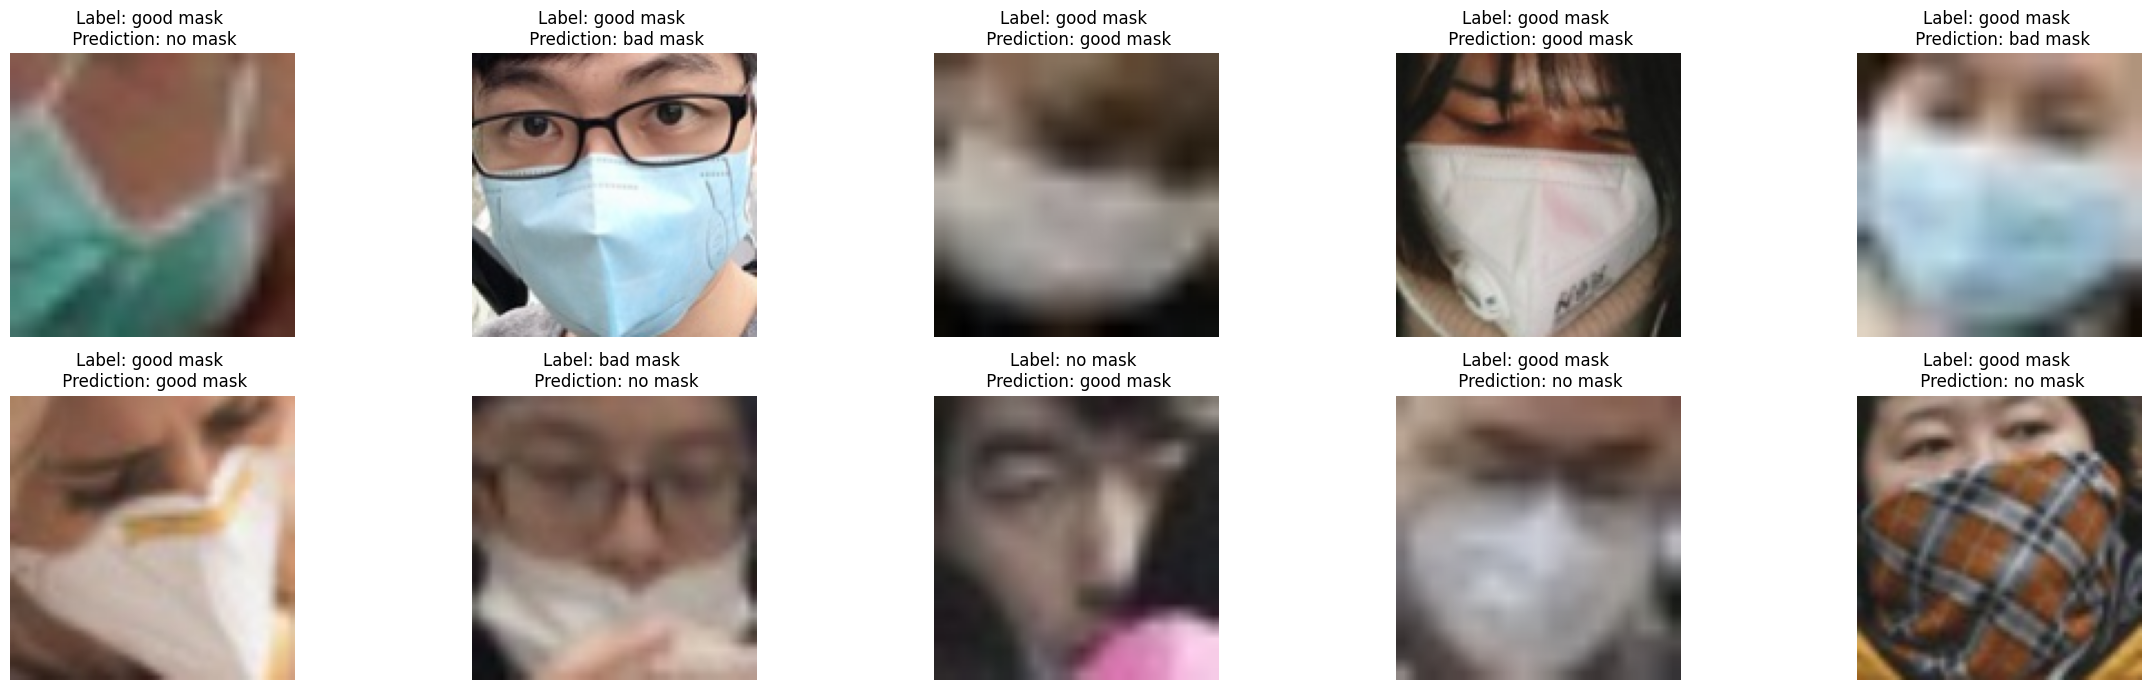

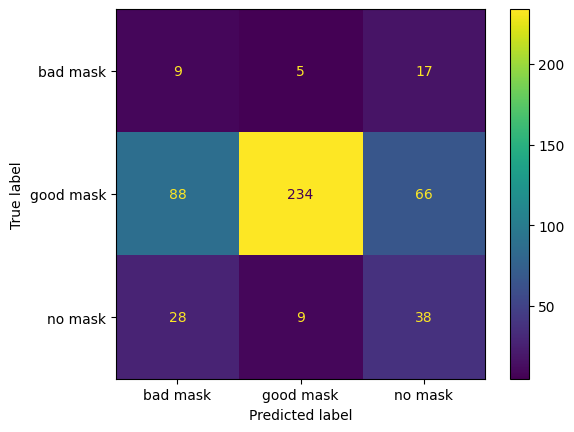

Classification report for classifier GridSearchCV(cv=5, estimator=SVC(gamma=0.1),
             param_grid={'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]}):
                    precision    recall  f1-score   support

    bad mask       0.07      0.29      0.12        31
   good mask       0.94      0.60      0.74       388
     no mask       0.31      0.51      0.39        75

    accuracy                           0.57       494
   macro avg       0.44      0.47      0.41       494
weighted avg       0.79      0.57      0.64       494




In [59]:
hist_list = []

for i in range(len(X_test)):
    img = img_as_ubyte(color.rgb2gray(X_test[i]))
    kp, des = sift.detectAndCompute(img, None)

    if des is not None:
        hist = np.zeros(k)

        idx = kmeans.predict(des)

        for j in idx:
            hist[j] = hist[j] + (1 / len(des))

        hist_list.append(hist)

    else:
        hist_list.append(None)

# Remove potential cases of images with no descriptors
idx_not_empty = [i for i, x in enumerate(hist_list) if x is not None]
hist_list = [hist_list[i] for i in idx_not_empty]
y_test = [y_test[i] for i in idx_not_empty]
hist_array = np.vstack(hist_list)

y_pred = classifier.predict(hist_array).tolist()

fig, axes = plt.subplots(2, 5, figsize=(24, 7))
ax = axes.ravel()

for i in range(10):
    ax[i].imshow(X_test[i])
    ax[i].set_title(f'Label: {y_test[i]} \n Prediction: {y_pred[i]}')
    ax[i].set_axis_off()
fig.tight_layout()
plt.show()

metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

print(f"""Classification report for classifier {classifier}:
      {metrics.classification_report(y_test, y_pred)}\n""")

## Final analysis SIFT + SVM

use validation set


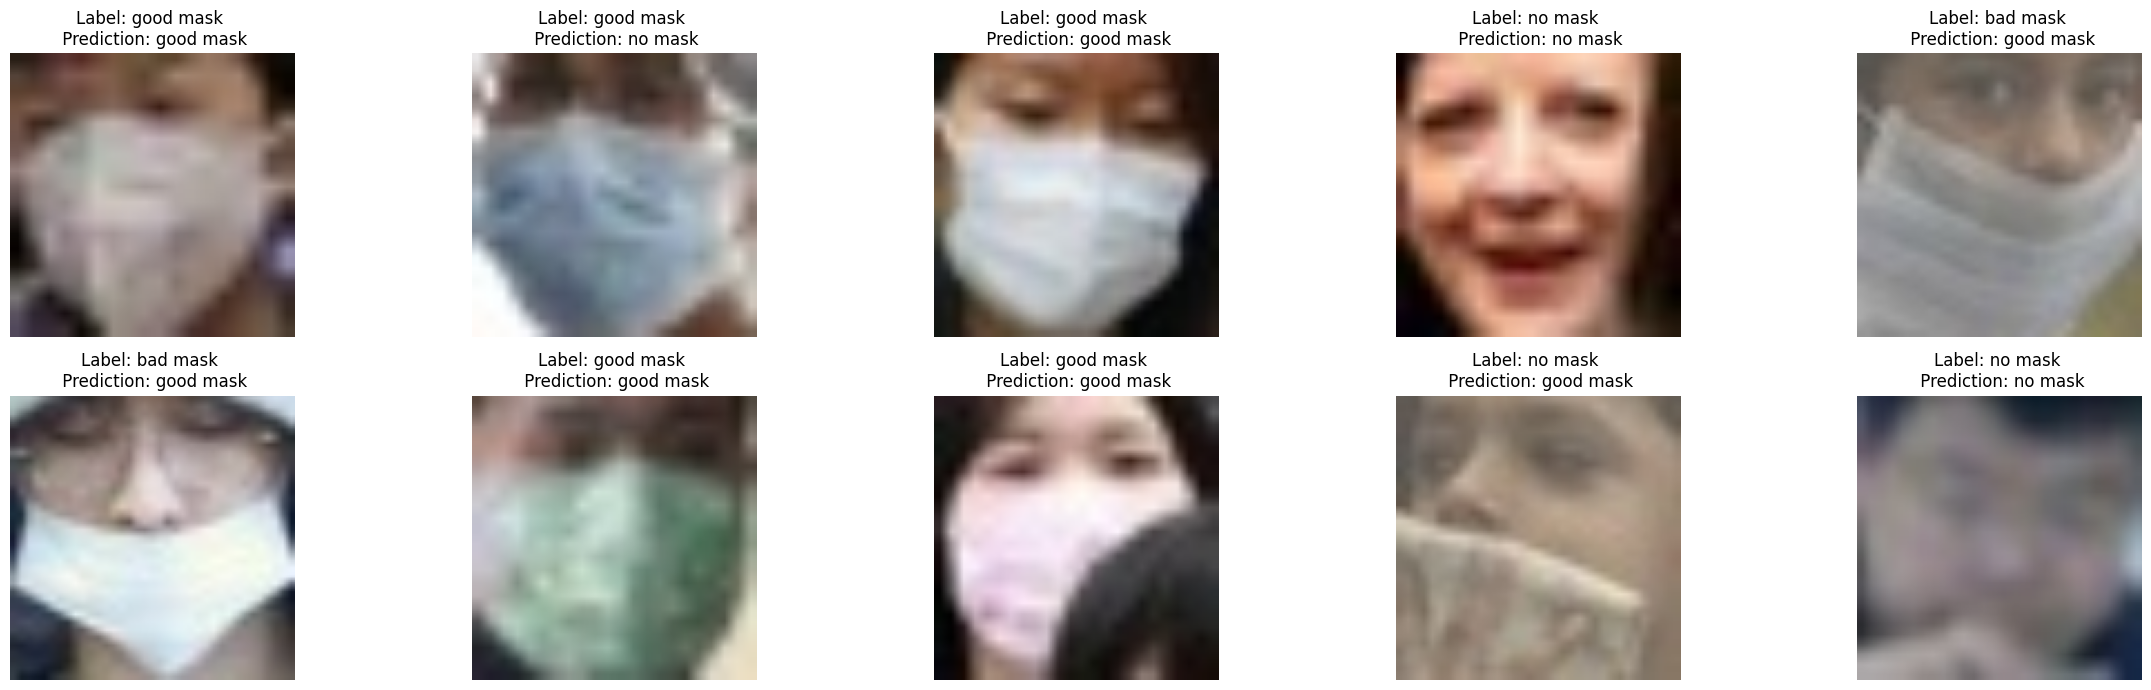

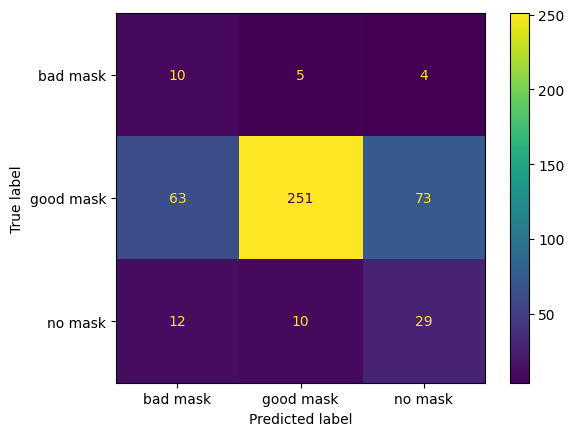

Classification report for classifier GridSearchCV(cv=5, estimator=SVC(gamma=0.1),
             param_grid={'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]}):
                    precision    recall  f1-score   support

    bad mask       0.12      0.53      0.19        19
   good mask       0.94      0.65      0.77       387
     no mask       0.27      0.57      0.37        51

    accuracy                           0.63       457
   macro avg       0.44      0.58      0.44       457
weighted avg       0.83      0.63      0.70       457




In [65]:
X_validation, y_validation = import_selected_data("test")

hist_list = []

loadDataImbalanced()

for i in range(len(X_validation)):
    img = img_as_ubyte(color.rgb2gray(X_validation[i]))
    kp, des = sift.detectAndCompute(img, None)

    if des is not None:
        hist = np.zeros(k)

        idx = kmeans.predict(des)

        for j in idx:
            hist[j] = hist[j] + (1 / len(des))

        hist_list.append(hist)

    else:
        hist_list.append(None)

# Remove potential cases of images with no descriptors
idx_not_empty = [i for i, x in enumerate(hist_list) if x is not None]
hist_list = [hist_list[i] for i in idx_not_empty]
y_validation = [y_validation[i] for i in idx_not_empty]
hist_array = np.vstack(hist_list)

y_pred = classifier.predict(hist_array).tolist()

fig, axes = plt.subplots(2, 5, figsize=(24, 7))
ax = axes.ravel()

for i in range(10):
    ax[i].imshow(X_validation[i])
    ax[i].set_title(f'Label: {y_validation[i]} \n Prediction: {y_pred[i]}')
    ax[i].set_axis_off()
fig.tight_layout()
plt.show()

metrics.ConfusionMatrixDisplay.from_predictions(y_validation, y_pred)
plt.show()

print(f"""Classification report for classifier {classifier}:
      {metrics.classification_report(y_validation, y_pred)}\n""")

Ngl kowalski SIFT + SVM is pretty trash...

# HOG + SVM

ref lab 5 & 6

In [25]:
from skimage.feature import hog
from skimage import exposure
from joblib import dump

## Extract HOG descriptors

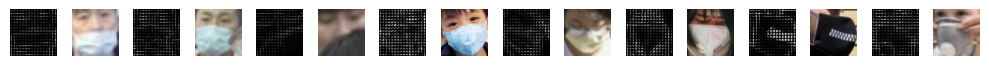

In [66]:
loadDataImbalanced()

fig, ax = plt.subplots(1, 16, figsize=(10, 8))

des_list = []
y_train_list = []

for i in range(len(X_train)):
    # Identify keypoints and extract descriptors with SIFT
    HOG_des, HOG_image = hog(X_train[i], orientations=8, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True, channel_axis=2)

    # Show results for first 4 images
    if i<8:
      HOG_image_rescaled = exposure.rescale_intensity(HOG_image, in_range=(0, 10))

      ax[(i*2) + 1].set_axis_off()
      ax[(i*2) + 1].imshow(X_train[i])

      ax[(i*2)].set_axis_off()
      ax[(i*2)].imshow(HOG_image_rescaled, cmap='gray')

    des_list.append(HOG_des)
    y_train_list.append(y_train[i])


fig.tight_layout()
plt.show()

hist_array = np.vstack(des_list)

## Train SVM

In [67]:
# Create a classifier: a support vector classifier
classifier = svm.SVC(kernel='linear', class_weight='balanced')
params = {'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5]}
classifier = GridSearchCV(classifier, params, cv=5) #ref https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
classifier.fit(hist_array, y_train)

print("Best C:", classifier.best_params_['C'])
print("Best score:", classifier.best_score_)

dump(classifier, 'HOG_SVM.joblib')

Best C: 0.05
Best score: 0.8432067510548524


['HOG_SVM.joblib']

In [68]:
from joblib import load

classifier = load('HOG_SVM.joblib') #ref lab 6

## Analysis HOG + SVM

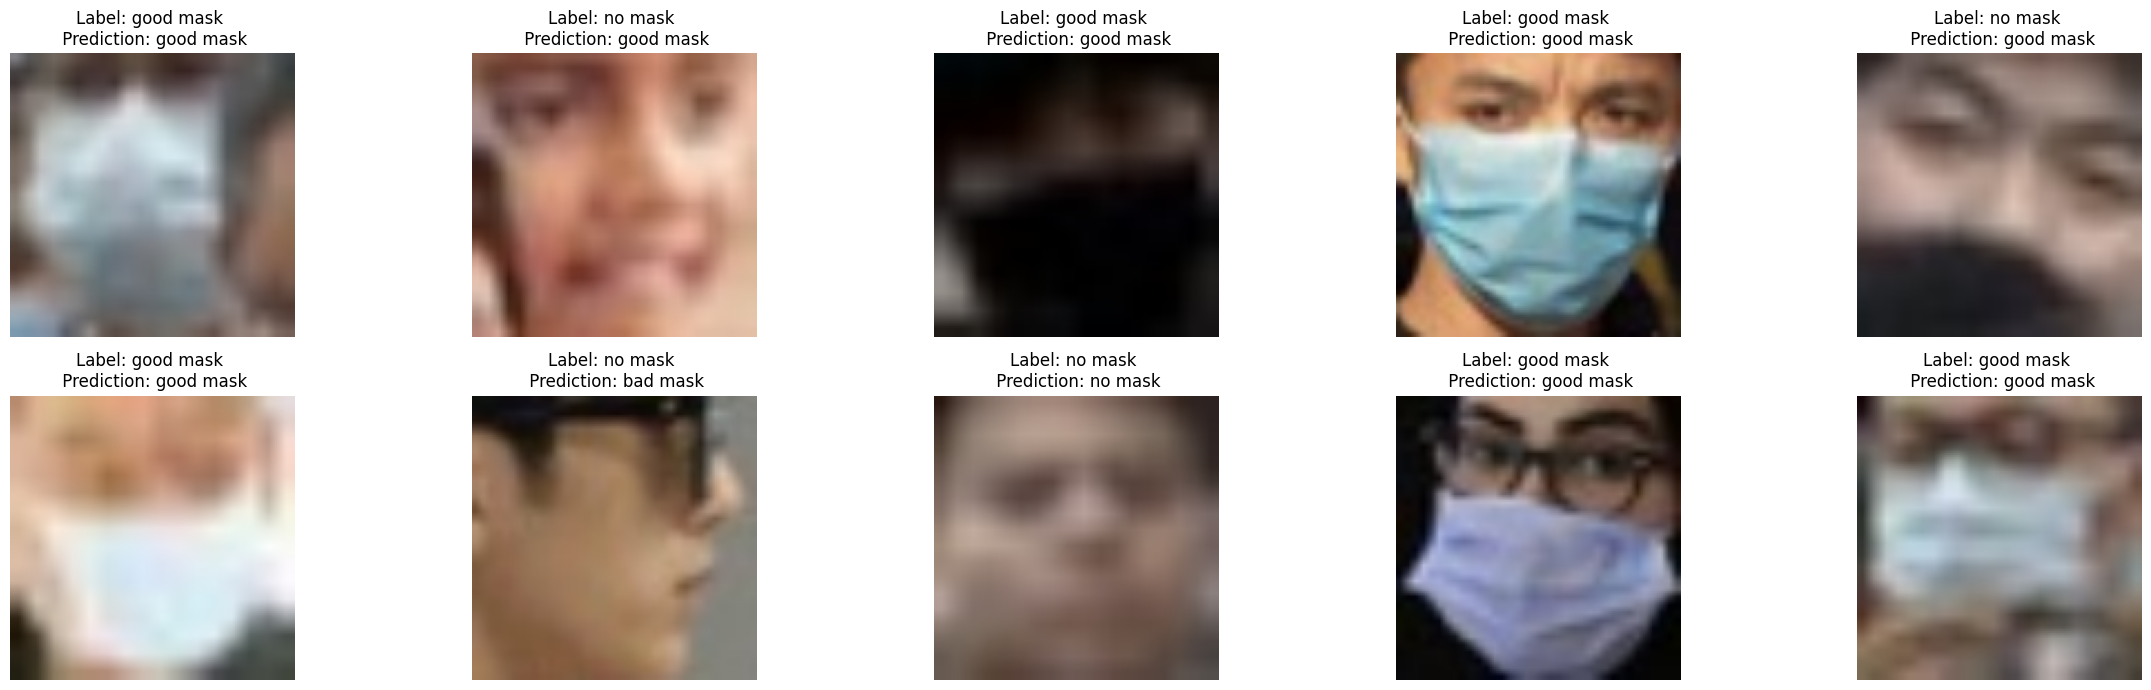

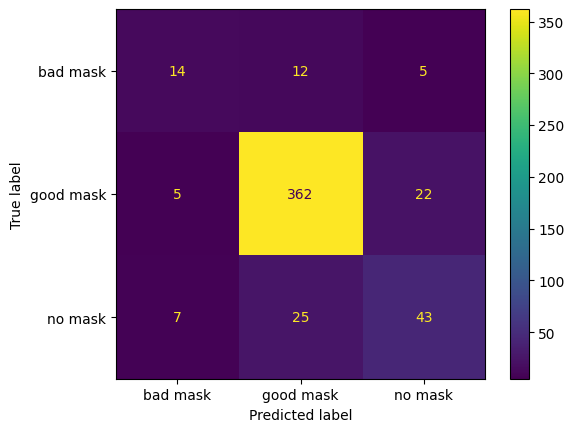

Classification report for classifier GridSearchCV(cv=5, estimator=SVC(class_weight='balanced', kernel='linear'),
             param_grid={'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5]}):
                    precision    recall  f1-score   support

    bad mask       0.54      0.45      0.49        31
   good mask       0.91      0.93      0.92       389
     no mask       0.61      0.57      0.59        75

    accuracy                           0.85       495
   macro avg       0.69      0.65      0.67       495
weighted avg       0.84      0.85      0.84       495




In [69]:
des_list = []

for i in range(len(X_test)):
    HOG_des, HOG_image = hog(X_test[i], orientations=8, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True, channel_axis=2)

    des_list.append(HOG_des)

hist_array = np.vstack(des_list)

y_pred = classifier.predict(hist_array).tolist()

fig, axes = plt.subplots(2, 5, figsize=(24, 7))
ax = axes.ravel()

for i in range(10):
    ax[i].imshow(X_test[i])
    ax[i].set_title(f'Label: {y_test[i]} \n Prediction: {y_pred[i]}')
    ax[i].set_axis_off()
fig.tight_layout()
plt.show()

metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

print(f"""Classification report for classifier {classifier}:
      {metrics.classification_report(y_test, y_pred)}\n""")

## Final analysis HOG + SVM

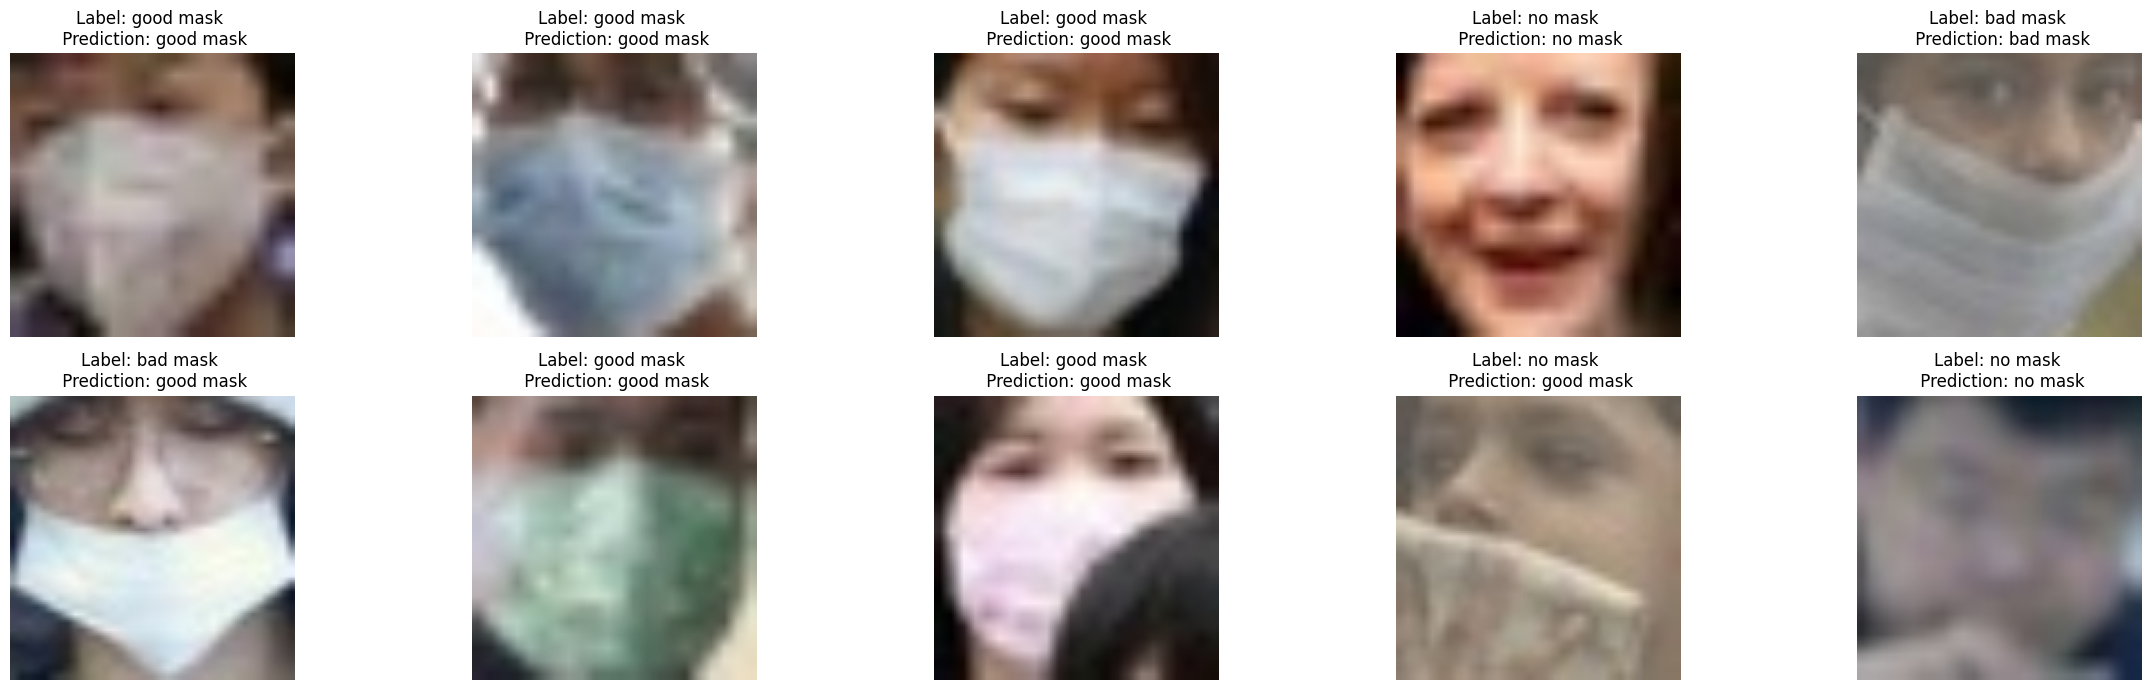

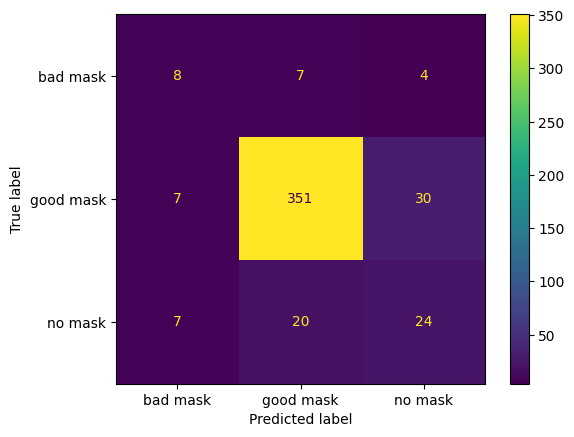

Classification report for classifier GridSearchCV(cv=5, estimator=SVC(class_weight='balanced', kernel='linear'),
             param_grid={'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5]}):
                    precision    recall  f1-score   support

    bad mask       0.36      0.42      0.39        19
   good mask       0.93      0.90      0.92       388
     no mask       0.41      0.47      0.44        51

    accuracy                           0.84       458
   macro avg       0.57      0.60      0.58       458
weighted avg       0.85      0.84      0.84       458




In [71]:
X_validation, y_validation = import_selected_data("test")


des_list = []

for i in range(len(X_validation)):
    HOG_des, HOG_image = hog(X_validation[i], orientations=8, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True, channel_axis=2)

    des_list.append(HOG_des)

hist_array = np.vstack(des_list)

y_pred = classifier.predict(hist_array).tolist()

fig, axes = plt.subplots(2, 5, figsize=(24, 7))
ax = axes.ravel()

for i in range(10):
    ax[i].imshow(X_validation[i])
    ax[i].set_title(f'Label: {y_validation[i]} \n Prediction: {y_pred[i]}')
    ax[i].set_axis_off()
fig.tight_layout()
plt.show()

metrics.ConfusionMatrixDisplay.from_predictions(y_validation, y_pred)
plt.show()

print(f"""Classification report for classifier {classifier}:
      {metrics.classification_report(y_validation, y_pred)}\n""")

# HOG + SIFT + MLP

Get SIFT BoVW

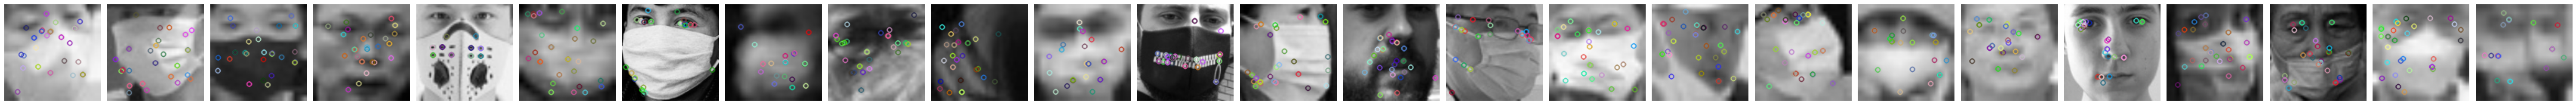

In [264]:
makeDataBalanced()

sift = cv2.SIFT_create(
    nfeatures=30,
    nOctaveLayers=15,
    contrastThreshold=0.008,
    edgeThreshold=8,
    sigma=1.000001
)

des_list = []
y_train_list = []


fig, ax = plt.subplots(1, 25, figsize=(60, 60))

for i in range(len(X_train_balanced)):
    img = img_as_ubyte(color.rgb2gray(X_train_balanced[i]))
    kp, des = sift.detectAndCompute(img, None)

    if i<25:
        img_with_SIFT = cv2.drawKeypoints(img, kp, img)
        ax[i].imshow(img_with_SIFT)
        ax[i].set_axis_off()

    if des is not None:
        des_list.append(des)
        y_train_list.append(y_train_balanced[i])

    else:
      des_list.append(np.zeros((1, 128), dtype=np.float32))
      y_train_list.append(y_train_balanced[i])


fig.tight_layout()
plt.show()

# Convert to array for easier handling
des_array = np.vstack(des_list)

k = len(np.unique(y_train)) * 10

# Use MiniBatchKMeans for faster computation and lower memory usage
batch_size = des_array.shape[0]
kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size, n_init='auto').fit(des_array)

# Convert descriptors into histograms of codewords for each image
hist_list = []
for des in des_list:
    if np.count_nonzero(des) == 0:
        hist = np.zeros(k)
    else:
        hist = np.zeros(k)
        idx = kmeans.predict(des)
        for j in idx:
            hist[j] = hist[j] + (1 / len(des))
    hist_list.append(hist)

sift_features = np.vstack(hist_list)


Get HOG

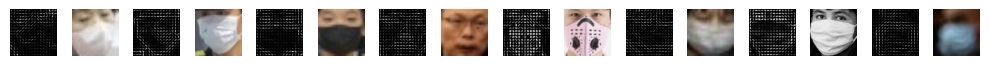

In [265]:
fig, ax = plt.subplots(1, 16, figsize=(10, 8))

des_list = []
y_train_list = []

for i in range(len(X_train_balanced)):
    # Identify keypoints and extract descriptors with SIFT
    HOG_des, HOG_image = hog(X_train_balanced[i], orientations=8, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True, channel_axis=2)

    # Show results for first 4 images
    if i<8:
      HOG_image_rescaled = exposure.rescale_intensity(HOG_image, in_range=(0, 10))

      ax[(i*2) + 1].set_axis_off()
      ax[(i*2) + 1].imshow(X_train_balanced[i])

      ax[(i*2)].set_axis_off()
      ax[(i*2)].imshow(HOG_image_rescaled, cmap='gray')

    des_list.append(HOG_des)
    y_train_list.append(y_train_balanced[i])


fig.tight_layout()
plt.show()

hog_features = np.vstack(des_list)

Combine HOG + SIFT

In [266]:
hog_features = hog_features.reshape(hog_features.shape[0], -1)
sift_features = sift_features.reshape(sift_features.shape[0], -1)
X_train_combined = np.hstack([hog_features, sift_features])


print("Train HOG shape:", hog_features.shape)
print("Train SIFT shape:", sift_features.shape)
print("Train combined shape:", X_train_combined.shape)

Train HOG shape: (4653, 7200)
Train SIFT shape: (4653, 30)
Train combined shape: (4653, 7230)


## Train
ref lab 6

Iteration 1, loss = 1.11317829
Iteration 2, loss = 1.05983530
Iteration 3, loss = 1.03399929
Iteration 4, loss = 1.00888283
Iteration 5, loss = 0.99496186
Iteration 6, loss = 0.97327093
Iteration 7, loss = 0.95593551
Iteration 8, loss = 0.93933192
Iteration 9, loss = 0.91927361
Iteration 10, loss = 0.90585396
Iteration 11, loss = 0.88997130
Iteration 12, loss = 0.88930576
Iteration 13, loss = 0.86723527
Iteration 14, loss = 0.85330696
Iteration 15, loss = 0.84054900
Iteration 16, loss = 0.83551009
Iteration 17, loss = 0.82563147
Iteration 18, loss = 0.81128667
Iteration 19, loss = 0.81105839
Iteration 20, loss = 0.79968725
Iteration 21, loss = 0.78581122
Iteration 22, loss = 0.77658957
Iteration 23, loss = 0.77892718
Iteration 24, loss = 0.77231842
Iteration 25, loss = 0.76054976
Iteration 26, loss = 0.76939105
Iteration 27, loss = 0.77054743
Iteration 28, loss = 0.78162702
Iteration 29, loss = 0.74062813
Iteration 30, loss = 0.73819699
Iteration 31, loss = 0.73083534
Iteration 32, los

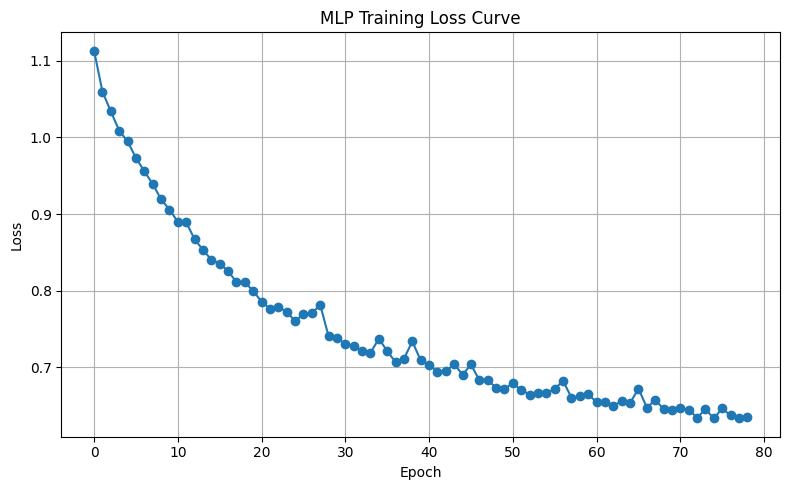

Training classification report:
              precision    recall  f1-score   support

    bad mask       0.64      0.79      0.71      1551
   good mask       0.65      0.70      0.67      1551
     no mask       0.81      0.55      0.65      1551

    accuracy                           0.68      4653
   macro avg       0.70      0.68      0.68      4653
weighted avg       0.70      0.68      0.68      4653



In [268]:
from sklearn.neural_network import MLPClassifier

classifier = MLPClassifier(
  hidden_layer_sizes=(128, 64),
  max_iter=200,
  alpha=0.05,
  solver='adam',
  verbose=True,
  random_state=56,
  learning_rate_init=.0005,
  n_iter_no_change=5,
  tol=0.001 # minimum required improvement
  )

classifier.fit(X_train_combined, y_train_balanced)

dump(classifier, 'SIFT_HOG_MLP.joblib')

y_train_pred = classifier.predict(X_train_combined)

plt.figure(figsize=(8, 5))
plt.plot(classifier.loss_curve_, marker='o')
plt.title('MLP Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.tight_layout()
plt.show()

print("Training classification report:")
print(metrics.classification_report(y_train_balanced, y_train_pred))

## Analysis

Test HOG shape: (495, 7200)
Test SIFT shape: (495, 30)
Test combined shape: (495, 7230)


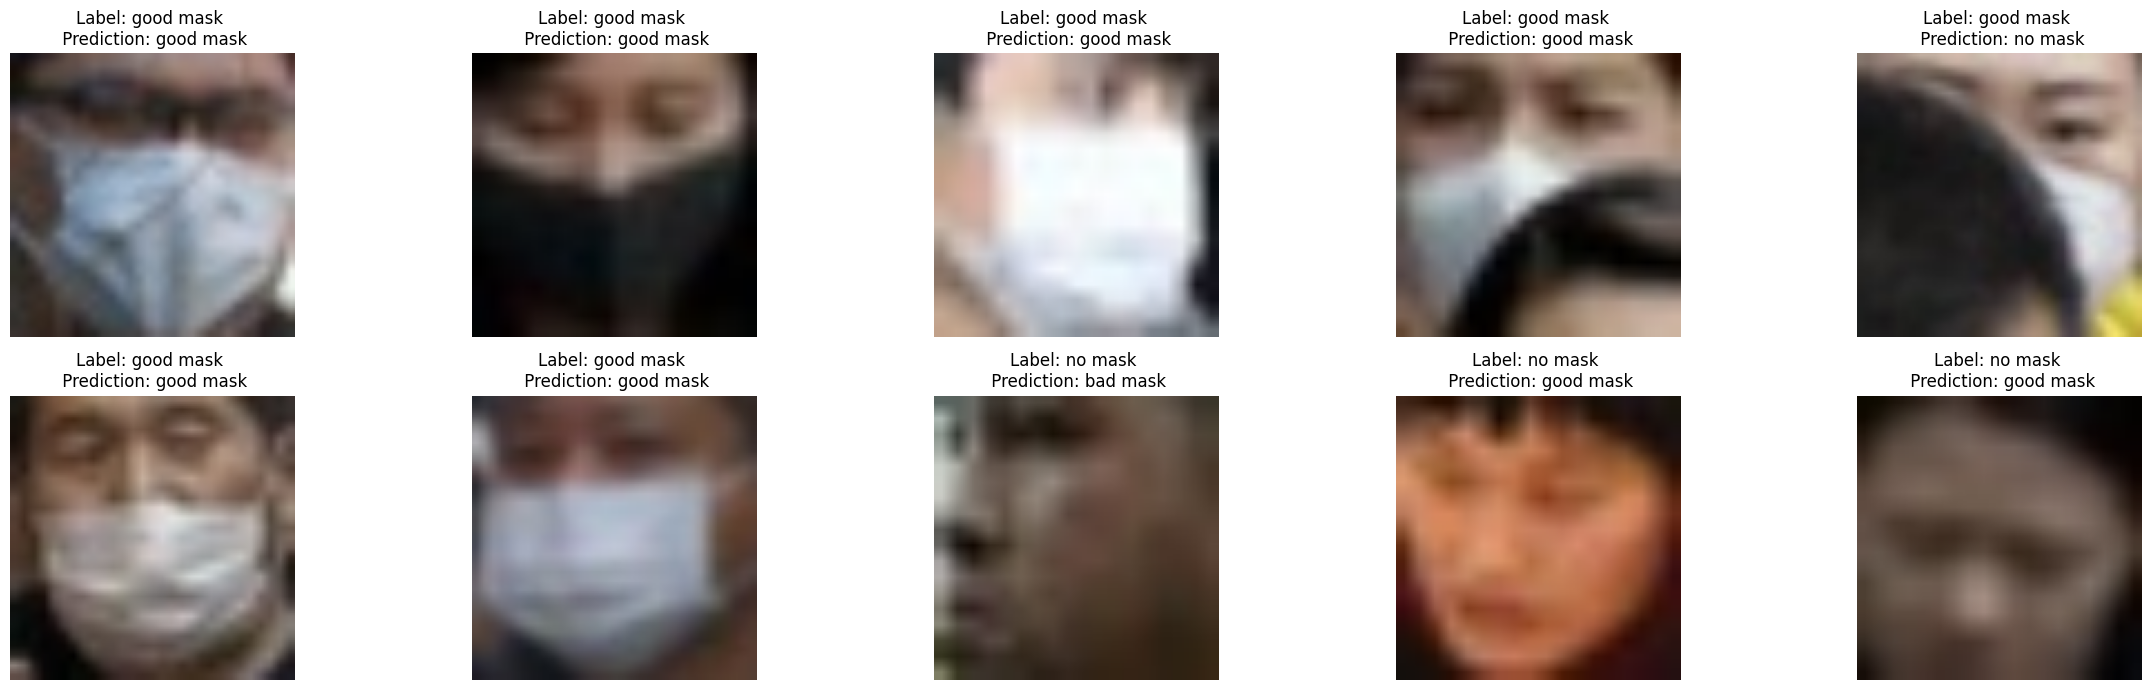

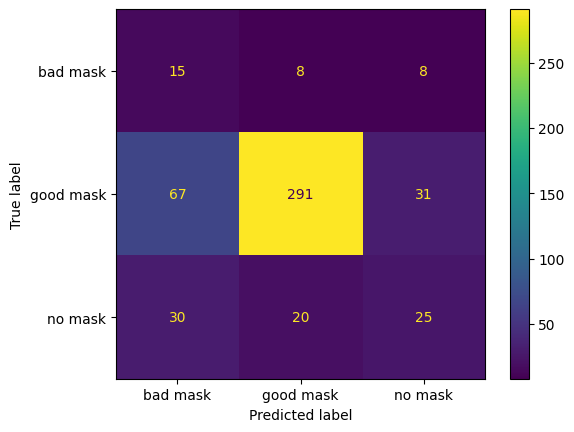

Classification report for classifier MLPClassifier(alpha=0.05, hidden_layer_sizes=(32, 10),
              learning_rate_init=0.0005, n_iter_no_change=5, random_state=56,
              tol=0.001, verbose=True):

                    precision    recall  f1-score   support

    bad mask       0.13      0.48      0.21        31
   good mask       0.91      0.75      0.82       389
     no mask       0.39      0.33      0.36        75

    accuracy                           0.67       495
   macro avg       0.48      0.52      0.46       495
weighted avg       0.78      0.67      0.71       495



In [269]:
classifier = load('SIFT_HOG_MLP.joblib') #ref lab 6


des_list = []
for i in range(len(X_test)):
    HOG_des, HOG_image = hog(X_test[i], orientations=8, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True, channel_axis=2)

    des_list.append(HOG_des)

hog_features = np.vstack(des_list)

hist_list = []
for i in range(len(X_test)):
    img = img_as_ubyte(color.rgb2gray(X_test[i]))
    kp, des = sift.detectAndCompute(img, None)

    if des is not None:
        hist = np.zeros(k)

        idx = kmeans.predict(des)

        for j in idx:
            hist[j] = hist[j] + (1 / len(des))

        hist_list.append(hist)

    else:
        hist_list.append(np.zeros(k))

sift_features = np.vstack(hist_list)

hog_features = hog_features.reshape(hog_features.shape[0], -1)
sift_features = sift_features.reshape(sift_features.shape[0], -1)
X_test_combined = np.hstack([hog_features, sift_features])

print("Test HOG shape:", hog_features.shape)
print("Test SIFT shape:", sift_features.shape)
print("Test combined shape:", X_test_combined.shape)

y_pred = classifier.predict(X_test_combined)

fig, axes = plt.subplots(2, 5, figsize=(24, 7))
ax = axes.ravel()

for i in range(10):
    ax[i].imshow(X_test[i])
    ax[i].set_title(f'Label: {y_test[i]} \n Prediction: {y_pred[i]}')
    ax[i].set_axis_off()
fig.tight_layout()
plt.show()

metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

print(f"""Classification report for classifier {classifier}:\n
      {metrics.classification_report(y_test, y_pred)}""")